In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
from PIL import Image
import time
import pandas as pd
import keras
import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle


In [3]:
## ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
## [   0   ,      1     ,     2    ,    3   ,   4  ,       5    ,     6    ]

fname = 'fer2013.csv'
df = read_csv(os.path.expanduser(fname))  
df['pixels'] = df['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
train_index=df['Usage']=="Training"   
validation_index=df['Usage']=="PublicTest"
test_index=df['Usage']=="PrivateTest"
train=df[train_index]   # training is training set
validation=df[validation_index] # validation is validation set
test=df[test_index]   # test is test set
X_train = np.vstack(train['pixels'].values) / 255.  # scale pixel values to [0, 1]
X_train = X_train.astype(np.float32)
y_train = train['emotion'].values
X_validation = np.vstack(validation['pixels'].values) / 255.  # scale pixel values to [0, 1]
X_validation = X_validation.astype(np.float32)
y_validation = validation['emotion'].values
X_test = np.vstack(test['pixels'].values) / 255.  # scale pixel values to [0, 1]
X_test = X_test.astype(np.float32)
y_test= test['emotion'].values
print(df.count())
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)
print(X_test.shape)
print(y_test.shape)
    

emotion    35887
pixels     35887
Usage      35887
dtype: int64
(28709, 2304)
(28709,)
(3589, 2304)
(3589,)
(3589, 2304)
(3589,)


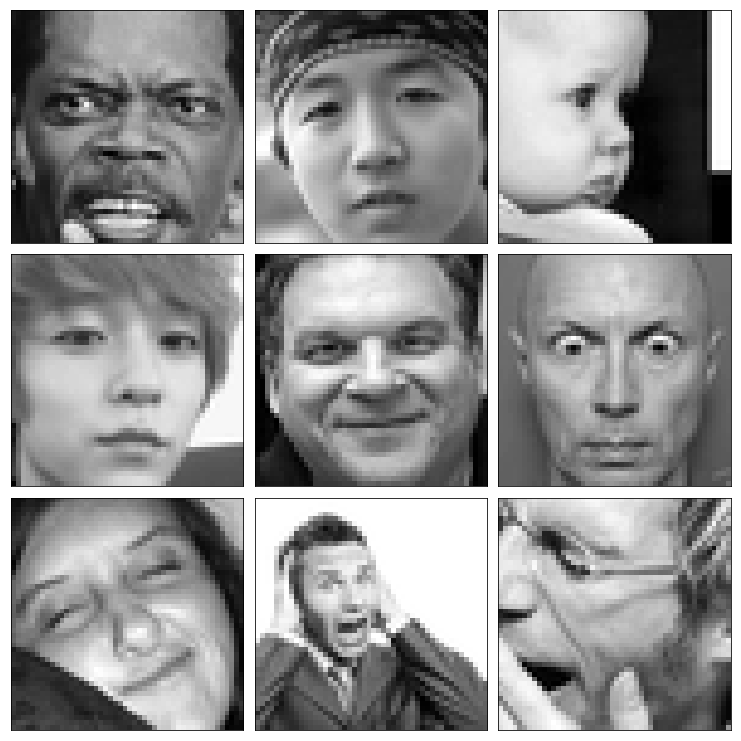

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(10,19):
    ax = fig.add_subplot(3, 3, i-10 + 1, xticks=[], yticks=[])
    ax.imshow(np.reshape(X_train[i],[48,48]), cmap='gray') # plot the image

In [ ]:
#Fisherface prediction
fishface = cv2.face.FisherFaceRecognizer_create()  
print("created")
def run_recognizer():
    training_data, training_labels, prediction_data, prediction_labels =X_train,y_train,X_validation,y_validation
    print ("training fisher face classifier")
    #print "size of training set is:", len(training_labels), "images"
    fishface.train(training_data, np.asarray(training_labels))
    print ("predicting classification set")
    cnt = 0
    correct = 0
    incorrect = 0
    i=0
    for image in prediction_data:
        i=i+1
        print("Iteration",i)
        pred, conf = fishface.predict(image)
        if pred == prediction_labels[cnt]:
            correct += 1
            cnt += 1
        else:
            incorrect += 1
            cnt += 1
    return ((100*correct)/(correct + incorrect))
#Now run it
metascore = []
for i in range(0,10):
    correct = run_recognizer()
    print ("got", correct, "percent correct!")
    metascore.append(correct)
print ("\n\nend score:", np.mean(metascore), "percent correct!") #32.59960991919755 percent accuracy

In [1]:
#CNN Prediction _ MODEL ONE
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.layers import Flatten, Dense


## TODO: Specify a CNN architecture
# Your model should accept 48x48 pixel graysale images

model = Sequential()

model.add(Convolution2D(4, (2, 2), input_shape=(48,48,1),activation='relu', padding="same"))
model.add(MaxPooling2D(2))
model.add(Dropout(0.1))

model.add(Convolution2D(8, (2, 2),activation='relu', padding="same"))
model.add(MaxPooling2D(2))
model.add(Dropout(0.1))

model.add(Convolution2D(16, (2, 2),activation='relu', padding="same"))
model.add(MaxPooling2D(2))
model.add(Dropout(0.1))

model.add(Convolution2D(32, (2, 2),activation='relu', padding="same"))
model.add(MaxPooling2D(2))
model.add(Dropout(0.1))

model.add(Convolution2D(64, (2, 2),activation='relu', padding="same"))
model.add(MaxPooling2D(2))
model.add(Dropout(0.1))

model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Dense(128,activation="relu"))
model.add(Dropout(0.3))

model.add(Dense(64,activation="relu"))
model.add(Dropout(0.2))

# Output vector with 7 entries
model.add(Dense(7))
model.summary()

Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 4)         20        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 4)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 8)         136       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 8)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 8)         0         
_________________________________________________________________
con

In [ ]:
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam, Adamax, Nadam
from sklearn.preprocessing import OneHotEncoder

## TODO: Compile the model
model.compile(optimizer ='adam', loss='mse', metrics=['accuracy'])
## One hot encoding
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded=y_train
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y_train_onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#y_train_onehot_encoded.shape
#print(onehot_encoded)
## TODO: Train the model
hist = model.fit(np.reshape(X_train,[28709,48,48,1]), y_train_onehot_encoded, validation_split = 0.2, epochs = 150, batch_size=64, verbose=1)
## TODO: Save the model as my_model.h5
model.save('my_model_2.h5')    ## MODEL ONE


## MODEL ONE RESULTS 
## epochs=10  loss: 0.1105 - acc: 0.3367 - val_loss: 0.1068 - val_acc: 0.3624
## epochs=50  loss: 0.0985 - acc: 0.4378 - val_loss: 0.0952 - val_acc: 0.4530
## epochs=100 loss: 0.0945 - acc: 0.4715 - val_loss: 0.0914 - val_acc: 0.4916
## epochs=150 loss: 0.0920 - acc: 0.4951 - val_loss: 0.0902 - val_acc: 0.4955

## 50 percent accuracy

Train on 22967 samples, validate on 5742 samples
Epoch 1/150
22967/22967 [==============================] - 48s - loss: 0.0947 - acc: 0.4682 - val_loss: 0.0910 - val_acc: 0.4915
Epoch 2/150
22967/22967 [==============================] - 49s - loss: 0.0943 - acc: 0.4735 - val_loss: 0.0917 - val_acc: 0.4861
Epoch 3/150
22967/22967 [==============================] - 49s - loss: 0.0947 - acc: 0.4699 - val_loss: 0.0917 - val_acc: 0.4883
Epoch 4/150
22967/22967 [==============================] - 51s - loss: 0.0940 - acc: 0.4752 - val_loss: 0.0926 - val_acc: 0.4770
Epoch 5/150
22967/22967 [==============================] - 50s - loss: 0.0944 - acc: 0.4728 - val_loss: 0.0919 - val_acc: 0.4859
Epoch 6/150
22967/22967 [==============================] - 44s - loss: 0.0946 - acc: 0.4732 - val_loss: 0.0913 - val_acc: 0.4949
Epoch 7/150
22967/22967 [==============================] - 59s - loss: 0.0945 - acc: 0.4698 - val_loss: 0.0913 - val_acc: 0.4890
Epoch 8/150
22967/22967 [=======================

22967/22967 [==============================] - 46s - loss: 0.0924 - acc: 0.4879 - val_loss: 0.0907 - val_acc: 0.4922
Epoch 133/150
22967/22967 [==============================] - 42s - loss: 0.0926 - acc: 0.4883 - val_loss: 0.0903 - val_acc: 0.4983
Epoch 134/150
22967/22967 [==============================] - 49s - loss: 0.0923 - acc: 0.4908 - val_loss: 0.0910 - val_acc: 0.4902
Epoch 135/150
22967/22967 [==============================] - 47s - loss: 0.0927 - acc: 0.4860 - val_loss: 0.0907 - val_acc: 0.4939
Epoch 136/150
22967/22967 [==============================] - 43s - loss: 0.0924 - acc: 0.4897 - val_loss: 0.0926 - val_acc: 0.4793
Epoch 137/150
22967/22967 [==============================] - 43s - loss: 0.0929 - acc: 0.4897 - val_loss: 0.0908 - val_acc: 0.4864
Epoch 138/150
22967/22967 [==============================] - 42s - loss: 0.0924 - acc: 0.4888 - val_loss: 0.0902 - val_acc: 0.5000 0s - loss: 0.0924 - acc: 0.488
Epoch 139/150
22967/22967 [==============================] - 43s -

[0.21595809 0.03726739 0.15649208 0.08987007 0.30517006 0.01700419
 0.18317576]
[0.13315491 0.02250364 0.1173212  0.20704767 0.33284467 0.05072165
 0.13399374]
[0.13990843 0.02456715 0.18581916 0.30960363 0.21050383 0.02335456
 0.10510363]
[0.10206897 0.02335121 0.13127068 0.29630738 0.2664646  0.04232205
 0.13538662]
[0.26729062 0.03581433 0.17778616 0.05421717 0.31655532 0.03696378
 0.11091556]
[0.10128944 0.01087863 0.03917722 0.7327715  0.03621803 0.0267178
 0.04251355]
[0.15902443 0.02780089 0.1530878  0.0674801  0.2637149  0.03492785
 0.29369298]
[ 0.00499018  0.00817892 -0.03263371  0.9635817   0.00988455 -0.00300258
  0.03245273]
[0.09580033 0.01230087 0.29554588 0.12061714 0.28212875 0.0884944
 0.10866614]


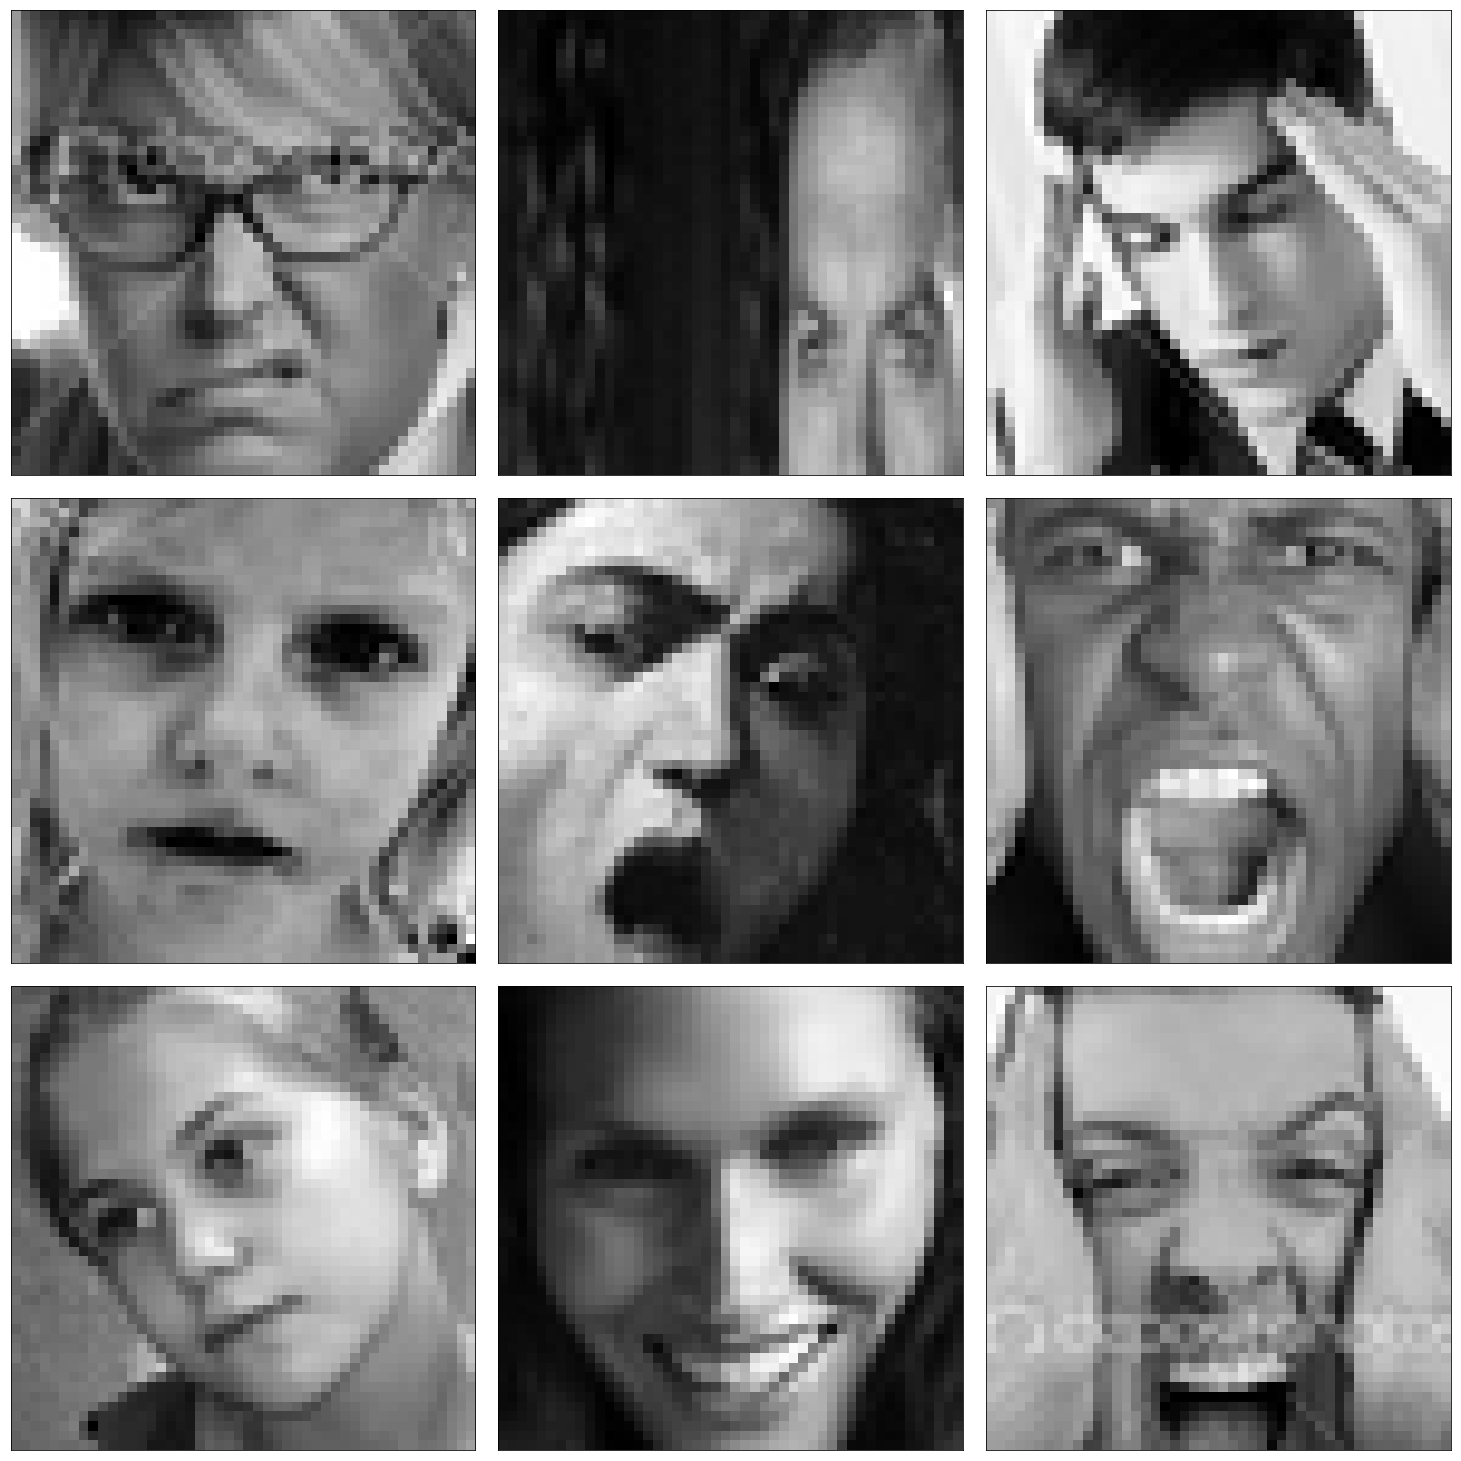

In [14]:
y_test_1 = model.predict(np.reshape(X_test,[3589,48,48,1]))
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(np.reshape(X_test[i],[48,48]), cmap='gray') # plot the image
    print(y_test_1[i])
    
## ['angry', 'disgusted', 'fearful', 'happy', 'sad', 'surprised', 'neutral']
## [   0   ,      1     ,     2    ,    3   ,   4  ,       5    ,     6    ]